#Optimization
This is an example of fitting a model to observed data. We'll conduct a variety of optimizations, to show a few examples of what's possible:

- Optimization over the full timeseries
- Step-at-a-time optimization, optimizing the model's ability to move from one known datapoint to another
- Optimization in the phase space


In [1]:
%pylab inline
import pandas as pd
import scipy.signal, scipy.optimize
import pysd
from IPython.display import display
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


### Import the data

For this example we'll use an example of a predator/prey system consisting of Didinium and Paramecium, that was described in:

    Veilleux (1976) "The analysis of a predatory interaction between Didinium and Paramecium", Masters thesis, University of Alberta.
    
The data we'll use was compiled from this work by [Christian Jost](http://robjhyndman.com/tsdldata/data/veilleux.dat).

I've extracted a subset of the data, which is seen here:

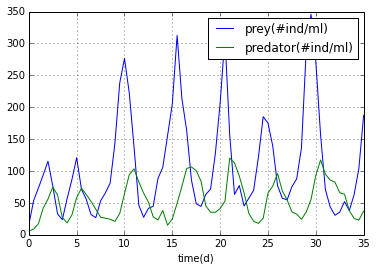

In [2]:
data = pd.read_csv('Veilleux_CC_0.5_Pretator_Prey.txt', sep='\s+', header=4, index_col='time(d)')
data.plot();

### Import the model

We'll use the standard [Lotkaâ€“Volterra Model](http://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equation) to describe the system. It consists of a predator population whose birth rate is limited by the prey population; and a prey population, whose death rate is governed by the predator population.

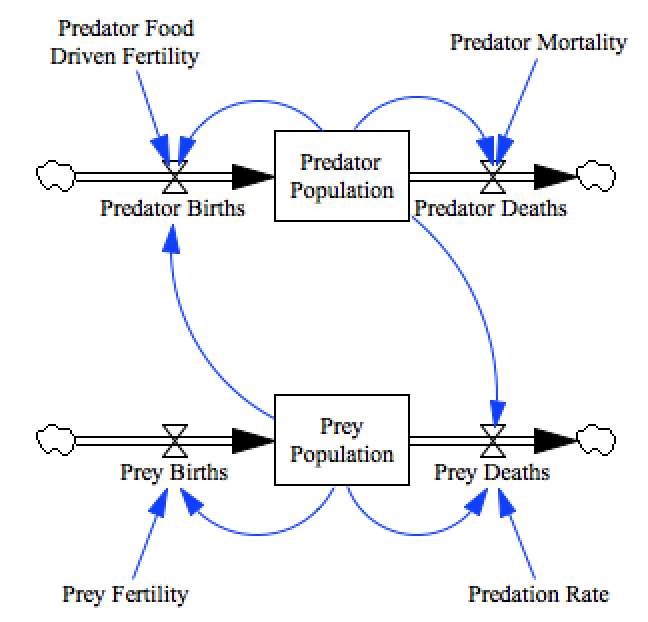

In [3]:
display(Image(filename='Predator_Prey.png', width=350))

In [4]:
model = pysd.read_vensim('Predator_Prey.mdl')
print model.stocknames
model.get_free_parameters()

['predator_population', 'prey_population']


{'predation_rate': '0.0001',
 'predator_food_driven_fertility': '0.001',
 'predator_mortality': '0.01',
 'predator_population_init': '100',
 'prey_fertility': '2',
 'prey_population_init': '250'}

Lets plug in some values for the simulation which give the general sort of behavior we're interested in: oscillations.

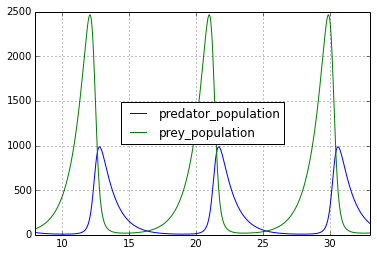

In [5]:
model.initial_values = [data.loc[8]['predator(#ind/ml)'], data.loc[8]['prey(#ind/ml)']]
model.tstart = 8
model.tstop = 33
params = {'predation_rate':.005,
          'prey_fertility':1,
          'predator_mortality':1,
          'predator_food_driven_fertility':.002}

sim_result = model.run(params=params)
sim_result.plot();

## Optimize Parameters to minimize timeseries error

The general approach to optimizing a model to fit timeseries data is to run the model over the same timespan as the data, with the same initial conditions, and compare the model's prediction to the dataset. We then use an optimizer to minimize the sum of the square of the error.

In [6]:
def timeseries_error(parameter_list):
    predation_rate, prey_fertility, predator_mortality, predator_food_driven_fertility = parameter_list
    
    sim_result = model.run(params={'predation_rate':predation_rate,
                                   'prey_fertility':prey_fertility,
                                   'predator_mortality':predator_mortality,
                                   'predator_food_driven_fertility':predator_food_driven_fertility})
    
    error = ((((sim_result['predator_population'] - data['predator(#ind/ml)']).dropna())**2).sum() + #sum of squares of predator pop error
             (((sim_result['prey_population'] - data['prey(#ind/ml)']).dropna())**2).sum()) #sum of squares of prey error
    
    print parameter_list, error
    return error

res = scipy.optimize.minimize(timeseries_error, x0=[.005, 1, 1, .002], method='L-BFGS-B', 
                              bounds=[(0,10), (0,None), (0,10), (0,None)])

[ 0.005  1.     1.     0.002] 37367596.6506
[ 0.005  1.     1.     0.002] 37367596.6506
[ 0.00500001  1.          1.          0.002     ] 37367548.4852
[ 0.005       1.00000001  1.          0.002     ] 37367596.8639
[ 0.005       1.          1.00000001  0.002     ] 37367597.2358
[ 0.005       1.          1.          0.00200001] 37367179.6726
[ 0.005  1.     1.     1.002] 146212554.748
[ 0.005  1.     1.     1.002] 146212554.748
[ 0.00500001  1.          1.          1.002     ] 146211956.285
[ 0.005       1.00000001  1.          1.002     ] 146212555.003
[ 0.005       1.          1.00000001  1.002     ] 146212552.741
[ 0.005       1.          1.          1.00200001] 146212557.2
[ 0.005       1.          1.          0.33457578] 28810315.8797
[ 0.005       1.          1.          0.33457578] 28810315.8797
[ 0.00500001  1.          1.          0.33457578] 28810196.5315
[ 0.005       1.00000001  1.          0.33457578] 28810315.9884
[ 0.005       1.          1.00000001  0.33457578] 28810315

[ 0.11811735  0.95929525  0.96527292  0.10345515] 1262960.65774
[ 0.11811735  0.95929524  0.96527293  0.10345515] 1262960.65716
[ 0.11811735  0.95929524  0.96527292  0.10345516] 1262960.66995
[ 0.20791477  0.87772419  0.88686554  0.05584   ] 1272839.24696
[ 0.20791477  0.87772419  0.88686554  0.05584   ] 1272839.24696
[ 0.20791478  0.87772419  0.88686554  0.05584   ] 1272839.27459
[ 0.20791477  0.8777242   0.88686554  0.05584   ] 1272839.23561
[ 0.20791477  0.87772419  0.88686555  0.05584   ] 1272839.23509
[ 0.20791477  0.87772419  0.88686554  0.05584001] 1272839.32356
[ 0.15204136  0.92847902  0.93565188  0.08546692] 1258449.23133
[ 0.15204136  0.92847902  0.93565188  0.08546692] 1258449.23133
[ 0.15204137  0.92847902  0.93565188  0.08546692] 1258449.23869
[ 0.15204136  0.92847903  0.93565188  0.08546692] 1258449.22835
[ 0.15204136  0.92847902  0.93565189  0.08546692] 1258449.22754
[ 0.15204136  0.92847902  0.93565188  0.08546693] 1258449.2586
[ 0.31025887  0.7829065   0.79551242  0. 

Plotting the result next to the data shows some of the limitations of this approach:

  status: 0
 success: True
    nfev: 38
     fun: 1134088.3162719884
       x: array([ 0.22092854,  0.82568278,  0.83193825,  0.01817016])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([ -162688.73587251,   247965.59009701,   125558.97701532,
       -1443415.06529599])
     nit: 21

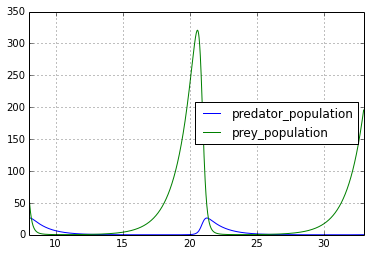

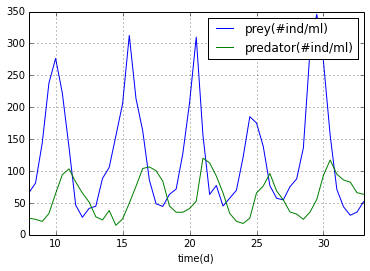

In [7]:
predation_rate, prey_fertility, predator_mortality, predator_food_driven_fertility = res.x

sim_result = model.run(params={'predation_rate':predation_rate,
                               'prey_fertility':prey_fertility,
                                'predator_mortality':predator_mortality,
                                'predator_food_driven_fertility':predator_food_driven_fertility})


sim_result.plot()
data.loc[8:33].plot()

res

### Optimize for step-at-a-time timeseries error

Instead of running over the full timeseries at once, and trying to minimize the error between this output and the data, lets initialize the model to one of the datapoints, and run it forward by one timestep in the data series, and compare the result. We can do this for every point in the dataset, asking the model merely to predict forward one step at a time.

In [8]:
def timestep_error(parameter_list):
    predation_rate, prey_fertility, predator_mortality, predator_food_driven_fertility = parameter_list
    
    error = 0
    for i_current, i_next in zip(data.index[:-1], data.index[1:]):
        model.tstart = i_current
        model.tstop = i_next + model.dt #include the next datapoint
        model.initial_values = [data.loc[i_current]['predator(#ind/ml)'], data.loc[i_current]['prey(#ind/ml)']]
        
        sim_result = model.run(params={'predation_rate':predation_rate,
                                       'prey_fertility':prey_fertility,
                                       'predator_mortality':predator_mortality,
                                       'predator_food_driven_fertility':predator_food_driven_fertility})
        
        error += ((sim_result['predator_population'].loc[i_next] - data['predator(#ind/ml)'].loc[i_next])**2 +
                  (sim_result['prey_population'].loc[i_next] - data['prey(#ind/ml)'].loc[i_next])**2)
        
    print parameter_list, error
    return error

res = scipy.optimize.minimize(timestep_error, x0=[.005, 1, 1, .002], method='L-BFGS-B', 
                              bounds=[(0,10), (0,None), (0,10), (0,None)])

[ 0.005  1.     1.     0.002] 545152.624991
[ 0.005  1.     1.     0.002] 545152.624991
[ 0.00500001  1.          1.          0.002     ] 545152.067845
[ 0.005       1.00000001  1.          0.002     ] 545152.634383
[ 0.005       1.          1.00000001  0.002     ] 545152.626173
[ 0.005       1.          1.          0.00200001] 545152.342854
[ 0.00500035  0.99999996  0.99999996  1.002     ] 21776952288.7
[ 0.00500035  0.99999996  0.99999996  1.002     ] 21776952288.7
[ 0.00500036  0.99999996  0.99999996  1.002     ] 21776863989.6
[ 0.00500035  0.99999997  0.99999996  1.002     ] 21776952305.6
[ 0.00500035  0.99999996  0.99999997  1.002     ] 21776952088.2
[ 0.00500035  0.99999996  0.99999996  1.00200001] 21776952695.0
[ 0.005       1.          1.          0.00256964] 529047.703304
[ 0.005       1.          1.          0.00256964] 529047.703304
[ 0.00500001  1.          1.          0.00256964] 529047.137462
[ 0.005       1.00000001  1.          0.00256964] 529047.712497
[ 0.005       1.

[ 0.02459753  1.29075235  0.98107564  0.00657862] 76020.1857867
[ 0.02459753  1.29075234  0.98107565  0.00657862] 76020.1862363
[ 0.02459753  1.29075234  0.98107564  0.00657863] 76020.1403931
[ 0.02681734  1.43210987  0.97187161  0.00684952] 72955.3485346
[ 0.02681734  1.43210987  0.97187161  0.00684952] 72955.3485346
[ 0.02681735  1.43210987  0.97187161  0.00684952] 72955.3509989
[ 0.02681734  1.43210988  0.97187161  0.00684952] 72955.3484517
[ 0.02681734  1.43210987  0.97187162  0.00684952] 72955.348722
[ 0.02681734  1.43210987  0.97187161  0.00684953] 72955.3177417
[ 0.02711581  1.48831988  0.96820237  0.00742441] 71612.1219043
[ 0.02711581  1.48831988  0.96820237  0.00742441] 71612.1219043
[ 0.02711582  1.48831988  0.96820237  0.00742441] 71612.126629
[ 0.02711581  1.48831989  0.96820237  0.00742441] 71612.1218578
[ 0.02711581  1.48831988  0.96820238  0.00742441] 71612.1219788
[ 0.02711581  1.48831988  0.96820237  0.00742442] 71612.1174038
[ 0.02638616  1.47638156  0.96897446  0.00

[ 0.02610283  1.46716367  0.85036647  0.00714727] 71031.0383554
[ 0.02612798  1.46888247  0.84990543  0.00714911] 71030.7953298
[ 0.02612798  1.46888247  0.84990543  0.00714911] 71030.7953298
[ 0.02612799  1.46888247  0.84990543  0.00714911] 71030.7953291
[ 0.02612798  1.46888248  0.84990543  0.00714911] 71030.7953297
[ 0.02612798  1.46888247  0.84990544  0.00714911] 71030.7953298
[ 0.02612798  1.46888247  0.84990543  0.00714912] 71030.7953221
[ 0.02612873  1.46893615  0.84984752  0.00714899] 71030.7950392
[ 0.02612873  1.46893615  0.84984752  0.00714899] 71030.7950392
[ 0.02612874  1.46893615  0.84984752  0.00714899] 71030.795039
[ 0.02612873  1.46893616  0.84984752  0.00714899] 71030.7950392
[ 0.02612873  1.46893615  0.84984753  0.00714899] 71030.7950392
[ 0.02612873  1.46893615  0.84984752  0.007149  ] 71030.7950388
[ 0.02612874  1.46893636  0.84984715  0.00714899] 71030.7950389
[ 0.02612874  1.46893636  0.84984715  0.00714899] 71030.7950389
[ 0.02612875  1.46893636  0.84984715  0.0

In this case we see that the model converges to a solution (even run over the full length of the simulation) which approximates the data much more closely.

  status: 0
 success: True
    nfev: 46
     fun: 71030.795038949465
       x: array([ 0.02612874,  1.46893636,  0.84984715,  0.00714899])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([-0.75815478,  0.11641532,  0.06984919, -1.36060407])
     nit: 34

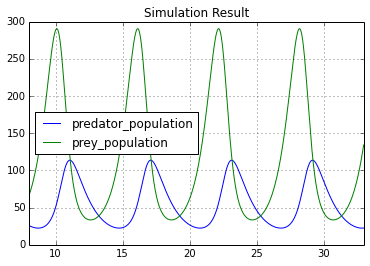

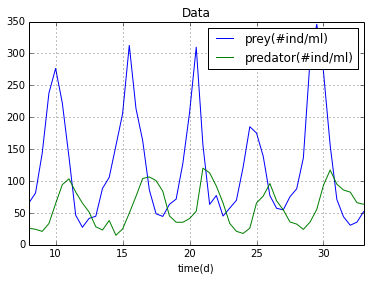

In [9]:
predation_rate, prey_fertility, predator_mortality, predator_food_driven_fertility = res.x

model.initial_values = [data.loc[8]['predator(#ind/ml)'], data.loc[8]['prey(#ind/ml)']]
model.tstart = 8
model.tstop = 33

sim_result = model.run(params={'predation_rate':predation_rate,
                               'prey_fertility':prey_fertility,
                                'predator_mortality':predator_mortality,
                                'predator_food_driven_fertility':predator_food_driven_fertility})

sim_result.plot(title='Simulation Result')
data.loc[8:33].plot(title='Data')
res

## Optimize for phase plane

We can also demonstrate some more interesting optimizations. Say for instance that we don't care about the frequency of the oscillations, merely the lead/lag behavior between the two populations. In this case we can optimize a model to fit the phase space cycle.

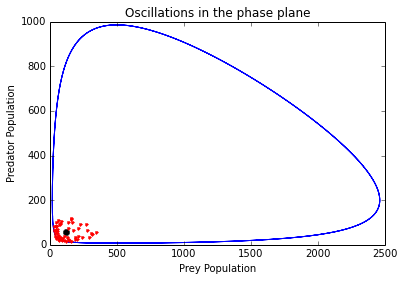

In [10]:
centroid = (data['prey(#ind/ml)'].loc[8:].mean(), data['predator(#ind/ml)'].loc[8:].mean())

model.initial_values = [data.loc[8]['predator(#ind/ml)'], data.loc[8]['prey(#ind/ml)']]
model.tstart = 8
model.tstop = 33
params = {'predation_rate':.005,
          'prey_fertility':1,
          'predator_mortality':1,
          'predator_food_driven_fertility':.002}

sim_result = model.run(params=params)


plt.plot(sim_result['prey_population'], sim_result['predator_population'])
plt.plot(centroid[0], centroid[1], 'ko')
plt.plot(data['prey(#ind/ml)'].loc[8:], data['predator(#ind/ml)'].loc[8:], 'r.')
plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
plt.title('Oscillations in the phase plane');

One way to manage the optimization is to convert the data and model output to radial coordinates around the centroid of the data in the phase plane.

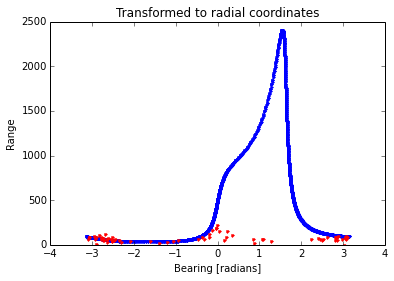

In [11]:
#coordinate transform
def transform((x, y), (x0, y0)):
    rrange = sqrt((x-x0)**2 + (y-y0)**2)
    rbearing = np.arctan2((y-y0),(x-x0))
    return rrange, rbearing

#transform the data to radial coordinates
data_transform = data.apply(lambda row: transform((row['prey(#ind/ml)'], row['predator(#ind/ml)']), centroid), 
                            axis=1, broadcast=True)
data_transform.columns = ['range', 'bearing']
data_transform.set_index('bearing', inplace=True)


sim_transform = sim_result.apply(lambda row: transform(row, centroid), axis=1, broadcast=True)
sim_transform.columns = ['range', 'bearing']
sim_transform.set_index('bearing', inplace=True)


plt.plot(sim_transform.index, sim_transform['range'], 'b.')
plt.plot(data_transform.index, data_transform['range'], 'r.')
plt.xlabel('Bearing [radians]')
plt.ylabel('Range')
plt.title('Transformed to radial coordinates');

As long as the centroid remains within our model's cycle, we can now minimize the radial error between the data and model predictions, run over the full timeseries.

In [12]:
def pp_error(parameter_list):
    predation_rate, prey_fertility, predator_mortality, predator_food_driven_fertility = parameter_list

    sim_result = model.run(params={'predation_rate':predation_rate,
                                   'prey_fertility':prey_fertility,
                                   'predator_mortality':predator_mortality,
                                   'predator_food_driven_fertility':predator_food_driven_fertility})
    
    #check that the centroid is still within the simulation oscillation
    if (sim_result['prey_population'].max() <= centroid[0] or
       sim_result['prey_population'].min() >= centroid[0] or
       sim_result['predator_population'].max() <= centroid[1] or 
       sim_result['predator_population'].min() >= centroid[1]):
            return 100000000

    #calculate error component due to radial coordiante phase plane range difference    
    sim_transform = sim_result.apply(lambda row: transform((row['prey_population'], row['predator_population'] ), 
                                                           centroid), axis=1, broadcast=True)
    sim_transform.columns = ['range', 'bearing']
    sim_transform.set_index('bearing', inplace=True)
    
    #interpolate to the data
    ts = pd.DataFrame(index=list(set(data_transform.index)-set(sim_transform.index)), columns=sim_transform.columns)
    sim_aligned = pd.concat([sim_transform, ts]).sort_index().interpolate().loc[data_transform.index].sort_index()

    #calculate the sum square error
    phase_plot_error = ((sim_aligned-data_transform)**2).sum().values[0]
    
    print parameter_list, phase_plot_error
    return  phase_plot_error
    

res = scipy.optimize.minimize(pp_error, x0=[.005, 1, 1, .002], method='L-BFGS-B', 
                              bounds=[(0,10), (0,None), (0,10), (0,None)])

[ 0.005  1.     1.     0.002] 29202226.6062
[ 0.005  1.     1.     0.002] 29202226.6062
[ 0.00500001  1.          1.          0.002     ] 29202117.4114
[ 0.005       1.00000001  1.          0.002     ] 29202224.3195
[ 0.005       1.          1.00000001  0.002     ] 29202226.0987
[ 0.005       1.          1.          0.00200001] 29201503.0266
[ 0.005       1.00316024  1.          1.00199501] 100000000
[ 0.005       1.00316024  1.          1.00199501] 100000000
[ 0.00500001  1.00316024  1.          1.00199501] 100000000
[ 0.005       1.00316025  1.          1.00199501] 100000000
[ 0.005       1.00316024  1.00000001  1.00199501] 100000000
[ 0.005       1.00316024  1.          1.00199502] 100000000
[ 0.005       1.00105136  1.          0.33468066] 100000000
[ 0.005       1.00105136  1.          0.33468066] 100000000
[ 0.00500001  1.00105136  1.          0.33468066] 100000000
[ 0.005       1.00105137  1.          0.33468066] 100000000
[ 0.005       1.00105136  1.00000001  0.33468066] 100000

[ 0.00499967  1.00003601  0.99999995  0.0134156 ] 384670.255059
[ 0.00499967  1.00003601  0.99999994  0.01341561] 384670.989947
[ 0.00499967  1.00003601  0.99999994  0.0134156 ] 384669.86267
[ 0.00499967  1.00003601  0.99999994  0.0134156 ] 384669.86267
[ 0.00499968  1.00003601  0.99999994  0.0134156 ] 384670.156471
[ 0.00499967  1.00003602  0.99999994  0.0134156 ] 384669.897642
[ 0.00499967  1.00003601  0.99999995  0.0134156 ] 384669.89339
[ 0.00499967  1.00003601  0.99999994  0.01341561] 384670.62827
[ 0.00499968  1.000036    0.99999993  0.01341532] 384648.810772
[ 0.00499968  1.000036    0.99999993  0.01341532] 384648.810772
[ 0.00499969  1.000036    0.99999993  0.01341532] 384649.104405
[ 0.00499968  1.00003601  0.99999993  0.01341532] 384648.845748
[ 0.00499968  1.000036    0.99999994  0.01341532] 384648.841486
[ 0.00499968  1.000036    0.99999993  0.01341533] 384649.576265
[ 0.00499969  1.00003599  0.99999993  0.01341513] 384634.91808
[ 0.00499969  1.00003599  0.99999993  0.01341

[ 0.0049997   1.00003599  0.99999992  0.01341506] 384526.579775
[ 0.0049997   1.00003599  0.99999992  0.01341506] 384526.579775
[ 0.00499971  1.00003599  0.99999992  0.01341506] 384526.904576
[ 0.0049997   1.000036    0.99999992  0.01341506] 384526.615065
[ 0.0049997   1.00003599  0.99999993  0.01341506] 384526.611163
[ 0.0049997   1.00003599  0.99999992  0.01341507] 384527.346743
[ 0.00499971  1.00003599  0.99999992  0.01341505] 385467.33992
[ 0.00499971  1.00003599  0.99999992  0.01341505] 385467.33992
[ 0.00499972  1.00003599  0.99999992  0.01341505] 384526.190609
[ 0.00499971  1.000036    0.99999992  0.01341505] 385467.377612
[ 0.00499971  1.00003599  0.99999993  0.01341505] 385467.375878
[ 0.00499971  1.00003599  0.99999992  0.01341506] 384526.632797
[ 0.0049997   1.00003599  0.99999992  0.01341506] 384526.579643
[ 0.0049997   1.00003599  0.99999992  0.01341506] 384526.579643
[ 0.00499971  1.00003599  0.99999992  0.01341506] 384526.904443
[ 0.0049997   1.000036    0.99999992  0.01

[ 0.03263929  2.165541    2.16541341  0.02648637] 164203.426531
[ 0.03263928  2.16554101  2.16541341  0.02648637] 164203.426658
[ 0.03263928  2.165541    2.16541342  0.02648637] 164203.425741
[ 0.03263928  2.165541    2.16541341  0.02648638] 164203.556433
[ 0.01493265  1.07281709  1.07282464  0.01184429] 120377.953432
[ 0.01493265  1.07281709  1.07282464  0.01184429] 120377.953432
[ 0.01493266  1.07281709  1.07282464  0.01184429] 120377.910277
[ 0.01493265  1.0728171   1.07282464  0.01184429] 120377.948925
[ 0.01493265  1.07281709  1.07282465  0.01184429] 120377.947663
[ 0.01493265  1.07281709  1.07282464  0.0118443 ] 120378.129024
[ 0.0109133   0.82477225  0.82481048  0.00852059] 105332.121629
[ 0.0109133   0.82477225  0.82481048  0.00852059] 105332.121629
[ 0.01091331  0.82477225  0.82481048  0.00852059] 105331.997768
[ 0.0109133   0.82477226  0.82481048  0.00852059] 105332.118129
[ 0.0109133   0.82477225  0.82481049  0.00852059] 105332.116637
[ 0.0109133   0.82477225  0.82481048  0.

[ 0.00986583  0.76013022  0.76017645  0.00765441] 102742.596105
[ 0.00986583  0.76013022  0.76017644  0.00765442] 102742.641783
[ 0.00986554  0.76011228  0.7601585   0.00765417] 102654.605914
[ 0.00986554  0.76011228  0.7601585   0.00765417] 102654.605914
[ 0.00986555  0.76011228  0.7601585   0.00765417] 102654.425041
[ 0.00986554  0.76011229  0.7601585   0.00765417] 102654.602656
[ 0.00986554  0.76011228  0.76015851  0.00765417] 102654.600917
[ 0.00986554  0.76011228  0.7601585   0.00765418] 102654.650768
[ 0.00986573  0.76012412  0.76017034  0.00765433] 102736.436685
[ 0.00986573  0.76012412  0.76017034  0.00765433] 102736.436685
[ 0.00986574  0.76012412  0.76017034  0.00765433] 102736.249095
[ 0.00986573  0.76012413  0.76017034  0.00765433] 102736.433131
[ 0.00986573  0.76012412  0.76017035  0.00765433] 102736.431308
[ 0.00986573  0.76012412  0.76017034  0.00765434] 102736.476918
[ 0.00986555  0.76011254  0.76015876  0.00765417] 102654.323244
[ 0.00986555  0.76011254  0.76015876  0.

[ 0.0120601   0.75228221  0.75233639  0.00619916] 57560.8957131
[ 0.0120601   0.75228221  0.75233639  0.00619916] 57560.8957131
[ 0.01206011  0.75228221  0.75233639  0.00619916] 57560.7946458
[ 0.0120601   0.75228222  0.75233639  0.00619916] 57560.8939132
[ 0.0120601   0.75228221  0.7523364   0.00619916] 57560.8946062
[ 0.0120601   0.75228221  0.75233639  0.00619917] 57560.674025
[ 0.01166342  0.75455693  0.75459802  0.00672226] 65449.8985074
[ 0.01166342  0.75455693  0.75459802  0.00672226] 65449.8985074
[ 0.01166343  0.75455693  0.75459802  0.00672226] 65449.820983
[ 0.01166342  0.75455694  0.75459802  0.00672226] 65449.8962372
[ 0.01166342  0.75455693  0.75459803  0.00672226] 65449.8957845
[ 0.01166342  0.75455693  0.75459802  0.00672227] 65449.911901
[ 0.01201139  0.75256155  0.75261413  0.0062634 ] 58142.6987431
[ 0.01201139  0.75256155  0.75261413  0.0062634 ] 58142.6987431
[ 0.0120114   0.75256155  0.75261413  0.0062634 ] 58142.6003175
[ 0.01201139  0.75256156  0.75261413  0.006

 130929.520564
[  1.00000000e+01   1.79997508e+05   1.00000000e+01   2.21688170e+07]Illegal input detected (internal error).
Run with full_output = 1 to get quantitative information.
 100000000
[  1.00000000e+01   1.79997508e+05   1.00000000e+01   2.21688170e+07] 100000000
[  1.00000000e+01   1.79997508e+05   1.00000000e+01   2.21688170e+07]Illegal input detected (internal error).
Run with full_output = 1 to get quantitative information.
 176056.447401
[  1.00000000e+01   1.79997508e+05   1.00000000e+01   2.21688170e+07] 100000000
[  1.00000000e+01   1.79997508e+05   1.00000000e+01   2.21688170e+07]Illegal input detected (internal error).
Run with full_output = 1 to get quantitative information.
 inf
[ 0.0120601   0.75228221  0.75233639  0.00619916] 57560.8957131
[ 0.0120601   0.75228221  0.75233639  0.00619916] 57560.8957131
[ 0.01206011  0.75228221  0.75233639  0.00619916] 57560.7946458
[ 0.0120601   0.75228222  0.75233639  0.00619916] 57560.8939132
[ 0.0120601   0.75228221  0.752336

  status: 0
 success: True
    nfev: 130
     fun: 57560.895713139231
       x: array([ 0.0120601 ,  0.75228221,  0.75233639,  0.00619916])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([-10106729.19801436,   -179996.75546889,   -110697.57238147,
       -22168817.0429843 ])
     nit: 14

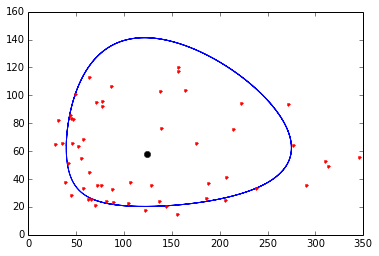

In [13]:
predation_rate, prey_fertility, predator_mortality, predator_food_driven_fertility = res.x


sim_result = model.run(params={'predation_rate':predation_rate,
                               'prey_fertility':prey_fertility,
                                'predator_mortality':predator_mortality,
                                'predator_food_driven_fertility':predator_food_driven_fertility})

plt.plot(sim_result['prey_population'], sim_result['predator_population'])
plt.plot(centroid[0], centroid[1], 'ko')
plt.plot(data['prey(#ind/ml)'].loc[8:], data['predator(#ind/ml)'].loc[8:], 'r.')

res

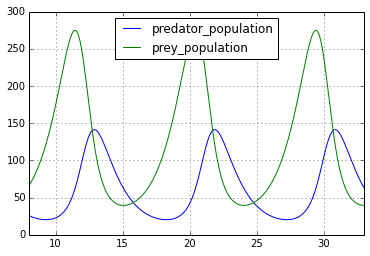

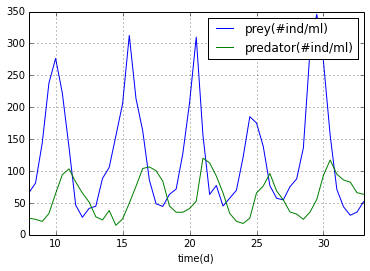

In [14]:
sim_result.plot()
data.loc[8:33].plot()